<a href="https://colab.research.google.com/github/csralvall/online_game_toxicity/blob/main/clustering_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import utility functions

In [1]:
from IPython.display import clear_output

### Install dependencies

In [2]:
# install dependencies
!pip install -U pip setuptools wheel pandas sklearn numpy gensim wget
clear_output()

### Import libraries

In [3]:
# import libraries
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from collections import Counter
from gensim.models import Word2Vec

### Setup dataframe print options

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Mount storage

In [5]:
# mount google drive unit to save computationally expensive results
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load subset of whole dataset from storage

In [6]:
# english chats from original dataset with anotations
eng_annotated = '/content/drive/MyDrive/nlp/dota2_chat_eng_annotated_2.csv'
df_test = pd.read_csv(eng_annotated)[:10000].dropna().reset_index(drop=True)

### Get bad word list from memory

In [7]:
# get downloaded bad word list
word_list = "/content/drive/MyDrive/nlp/bad_words.txt"
# use set for fast queries
bad_words = set(line.strip() for line in open(word_list, 'r'))
# add new bad words
bad_words.update(['noob', 'noobs', 'stfu', 'fukign', 'fuking', 'fukin', 'nooob'])
bad_dict = dict.fromkeys(bad_words, 0)

### Word2Vec embeddings:

In [8]:
# function to create embeddings of words in each chat
def generate_embedding_w2v(sentences: [[str]]):
  w2v_model = Word2Vec(
                     min_count=20,
                     window=2,
                     #size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=1)

  w2v_model.build_vocab(sentences, progress_per=10000)

  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

  return w2v_model

### Unroll chats as list of words

In [9]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [10]:
# from cleaned english chats get all of them without nan values
chats = df_test[['tokens']].dropna().astype(str).values
chats = flatten(chats)
vocab = list(map(lambda x: x.split(), chats))

### Generate word embeddings from chat

In [11]:
w2v_model = generate_embedding_w2v(vocab)

In [12]:
# save Word2Vec model
w2v_model.save('/content/drive/MyDrive/nlp/word2vec_2.model')

### Load word embeddings from disk

In [13]:
# load Word2Vec model
w2v_model = Word2Vec.load('/content/drive/MyDrive/nlp/word2vec_2.model')

### Embeddings utils

In [14]:
# generate embedding from chat
def chat_embedding(model, chat_words):
    chat_embedding = np.ones(100)
    for word in chat_words:
        if word in model.wv:
            chat_embedding *= model.wv[word] 
    return chat_embedding

### Clustering utils

In [15]:
def get_bad_vec(lexicon, chat_words):
    for word in chat_words:
        if word in lexicon:
            lexicon[word] += 1

    bad_vec = np.fromiter(lexicon.values(), dtype=int)
    
    return bad_vec

In [16]:
intensity = df_test[['intensity']].copy()

### Create w2v vectors for clustering

In [17]:
w2v_serie = np.array([])
for idx, chat in enumerate(chats):
    lexicon = dict.fromkeys(bad_words, 0)
    chat_intensity = intensity.loc[idx]
    chat_words = chat.split()
    bad_vec = get_bad_vec(lexicon, chat_words)
    w2v_embedding = chat_embedding(w2v_model, chat_words)
    w2v_bad_int_vec = np.hstack((w2v_embedding, bad_vec, chat_intensity)).ravel()
    w2v_serie = np.concatenate((w2v_serie, w2v_bad_int_vec))

### Reshape data

In [18]:
w2v_ncolumns = w2v_model.wv.vectors.shape[1] + len(bad_words) + 1
w2v_serie = w2v_serie.astype('float').reshape((-1, w2v_ncolumns))
w2v_matrix = w2v_serie[~np.isnan(w2v_serie)].reshape((-1, w2v_ncolumns))

### Matrix reduction

In [19]:
def reduce_matrix(matrix: np.ndarray, *, variance_treshold: float):
    print(f'INPUT SHAPE: {matrix.shape}')
    # reduce all vectors to [0, 1] space
    normalized_matrix = normalize(matrix, axis=1)
    # compute variances in each row
    matrix_variances = np.var(matrix, axis=0)
    # create mask for features with high correlation (low variance)
    bool_mask = np.where(matrix_variances < variance_treshold)
    # filter features with high correlation (variance under treshold)
    raked_matrix = np.delete(normalized_matrix, bool_mask, axis=1)
    print(f'OUTPUT SHAPE: {raked_matrix.shape}')
    return raked_matrix

### Reduce matrix

In [20]:
w2v_reduced = reduce_matrix(w2v_matrix, variance_treshold=0.01)

INPUT SHAPE: (10000, 1492)
OUTPUT SHAPE: (10000, 106)


### Save matrix

In [21]:
with open('/content/drive/MyDrive/nlp/w2v_serie_10000_2.npy', 'wb') as output_file:
    np.save(output_file, w2v_reduced)

### Load matrix from storage

In [22]:
w2v_reduced = np.load('/content/drive/MyDrive/nlp/w2v_serie_10000_2.npy')

### Clustering

In [23]:
def generate_clusters(
    matrix: np.ndarray,
    n_clusters: int
) -> KMeans:
    # generate word clusters using the KMeans algorithm.
    print("\nClustering started")
    # Instantiate KMeans clusterer for n_clusters
    km_model = KMeans(n_clusters=n_clusters, random_state=3)
    # create clusters
    km_model.fit(matrix)
    print("Clustering finished")
    return km_model

### Create clusters

In [24]:
w2v_clusters = generate_clusters(w2v_reduced, 40)


Clustering started
Clustering finished


### Cluster utility functions

In [25]:
def display_summary(clusters: KMeans):
    cluster_count = Counter(sorted(clusters.labels_))
    for cluster in cluster_count:
        print ("Cluster#", cluster," - Total words:", cluster_count[cluster])

In [26]:
def annotate_dataframe(clusters: KMeans, df: pd.DataFrame, col_name: str):
    cluster_count = Counter(sorted(clusters.labels_))
    #sort cluster centers by proximity to centroid
    order_centroids = clusters.cluster_centers_.argsort()[:, ::-1] 

    clusters_df = np.zeros(len(df))
    
    for cluster_idx in cluster_count:
        # get words inside each cluster
        cluster_words = np.where(clusters.labels_ == cluster_idx)[0]
        # anotate all chats in cluster
        for idx in cluster_words:
            clusters_df[idx] = int(cluster_idx)

    df[col_name] = clusters_df

### Show info about clusters

In [27]:
# show number of words captured by each cluster
display_summary(w2v_clusters)

Cluster# 0  - Total words: 6
Cluster# 1  - Total words: 1936
Cluster# 2  - Total words: 1745
Cluster# 3  - Total words: 369
Cluster# 4  - Total words: 355
Cluster# 5  - Total words: 315
Cluster# 6  - Total words: 703
Cluster# 7  - Total words: 95
Cluster# 8  - Total words: 139
Cluster# 9  - Total words: 98
Cluster# 10  - Total words: 83
Cluster# 11  - Total words: 75
Cluster# 12  - Total words: 71
Cluster# 13  - Total words: 77
Cluster# 14  - Total words: 62
Cluster# 15  - Total words: 87
Cluster# 16  - Total words: 59
Cluster# 17  - Total words: 82
Cluster# 18  - Total words: 147
Cluster# 19  - Total words: 34
Cluster# 20  - Total words: 115
Cluster# 21  - Total words: 30
Cluster# 22  - Total words: 43
Cluster# 23  - Total words: 10
Cluster# 24  - Total words: 150
Cluster# 25  - Total words: 2448
Cluster# 26  - Total words: 5
Cluster# 27  - Total words: 196
Cluster# 28  - Total words: 4
Cluster# 29  - Total words: 38
Cluster# 30  - Total words: 11
Cluster# 31  - Total words: 151
Clust

### Annotate cluster for each row in dataframe

In [28]:
df_test = df_test.copy()

In [29]:
annotate_dataframe(w2v_clusters, df_test, 'w2v_clusters')

In [47]:
df_test['nwords'] = list(map(lambda x: len(x.split()), df_test['tokens']))

In [48]:
df_test.to_csv(f'/content/drive/MyDrive/nlp/w2v_clusters_df_2.csv', index=False)

### Load FastText clusters

In [49]:
df_test = pd.read_csv('/content/drive/MyDrive/nlp/w2v_clusters_df_2.csv')

### Explore results

In [50]:
w2v_group = df_test.groupby('w2v_clusters')

Shilouette coeficient for this clustering

In [51]:
metrics.silhouette_score(w2v_reduced, w2v_clusters.labels_, metric='euclidean')

0.6137541220276498

#### Get toxicity score for each cluster

In [53]:
w2v_score = (w2v_group['toxicity'].sum() / w2v_group['nwords'].sum())
w2v_scored = pd.DataFrame({'score': w2v_score.values, 'size': w2v_group.size()})
w2v_scored = w2v_scored[w2v_scored['score'] > 0.13]
w2v_scored = w2v_scored.sort_values(by=['score', 'size'], ascending=[False, False])
top_toxic_clusters = w2v_scored.index.to_list()
w2v_scored

,score,size
w2v_clusters,,
26.0,0.769231,5
23.0,0.611111,10
19.0,0.590164,34
12.0,0.564286,71
22.0,0.557692,43
35.0,0.556818,23
30.0,0.534884,11
28.0,0.533333,4
14.0,0.464789,62


### Explore clusters

In [54]:
w2v_group.get_group(26)[['match','text']]

,match,text
178,87,fuck this shit nap team
3087,1785,fuck that shit
5017,2931,fuck off russians shit
5117,2991,fuck this shit
7028,3864,fuck this shit


In [55]:
w2v_group.get_group(23)[['match','text']]

,match,text
1120,636,so fucking noisy but just a piece of shit
2381,1421,fucking lucky shit
3109,1795,fucking shit ass lion
3407,1988,we did evry fucking shit for him
6555,3662,fucking trash russian shit
7066,3887,3 fucking piece of shit
7257,3974,fucking monkey shit
7713,4234,fucking piece of shit
7768,4253,you play 2 mid and call us try hard you fuckin...
8619,4672,fucking retarded shit


In [56]:
w2v_group.get_group(19)[['match','text']]

,match,text
279,129,but my teammates wont to kill u((9(
1122,636,u go kill then quit?
1145,671,and u didnt kill me its necro
1311,779,always kill supp
1609,1002,I won0't kill you
1878,1153,can only can kill me with ur 2 bodyguards
2019,1249,you kill top[
2163,1327,kill this monkey
2213,1345,how i kill all of you
2323,1395,or again kill you


In [57]:
w2v_group.get_group(12)[['match','text']]

,match,text
131,82,Ima out to fuck
203,107,i fuck your mum
235,121,what the fuck
244,121,what the fuck
307,153,where the fuck is snow
450,227,fuck you buyer
722,378,cant fuck with oracle!
1099,612,get the fuck out
1364,826,fuck off dudes
1639,1033,bc fuck u thats y


In [58]:
w2v_group.get_group(22)[['match', 'text']]

,match,text
215,111,fucking hard game ever when got lucky timing s...
241,121,ur mom is fucking slut
242,121,are fucking retard ursa
548,290,this lineup is fucking stupid
657,339,retard my fucking team
1014,554,fucking idiot offlaner
1089,598,report necro and fucking riki
1156,683,jugg you fucking moron
1182,702,go fucking kill him
1832,1125,Already pick first invoker and i playing my ro...


In [59]:
w2v_group.get_group(35)['text']

54                       yuou just fuck your ulti as hell
875                           they no skill fear the fuck
1758                                 die fuck your mother
2325                               shut the fuck up bitch
3290                            fuck off mid farm and die
3502    hey faggot ass woo ima show your stupid fuck h...
3503                            nah fuck that toxic cunt 
3516                                        fuck that kid
3915                                shut the fuck up cunt
5175            how the fuck can you deny xp to a sniper?
5585    why the fuck can you doom me during shadow realm?
6198    merry christmass kid picks morph even though h...
6788    he saw a sniper in enemy team and he say fuck ...
7107                                    injoker noob fuck
7489                                  fuck you mom retard
7590                          dont fuck with my bas bitch
7937                                 fuck u am u dog cunt
7943          

### Reduce dimensionality to display data

In [43]:
# use TSNE to reduce dimensionality of data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(w2v_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Display data without clusters

In [44]:
pointsspacy = pd.DataFrame(
    [(chat, coord[0], coord[1]) for (chat, coord) in zip(chats, matrix_dicc2d)],
    columns=["word", "x", "y"]
)

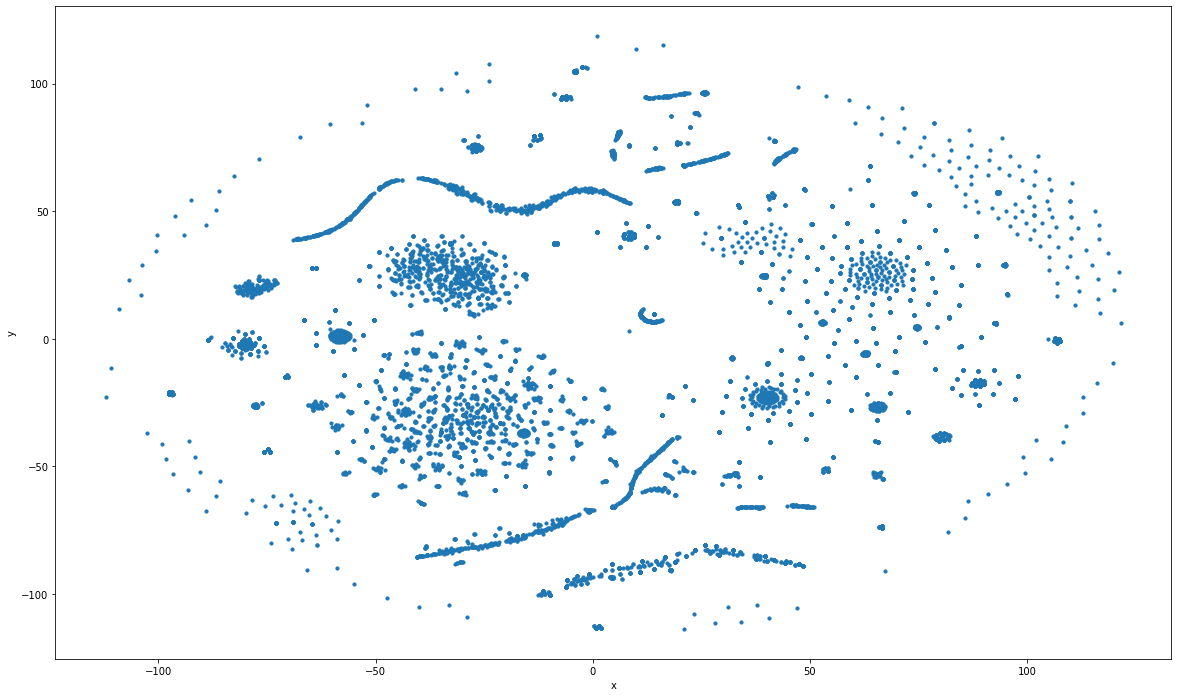

In [45]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Display clusters and clusters with biggest proportion of toxic words

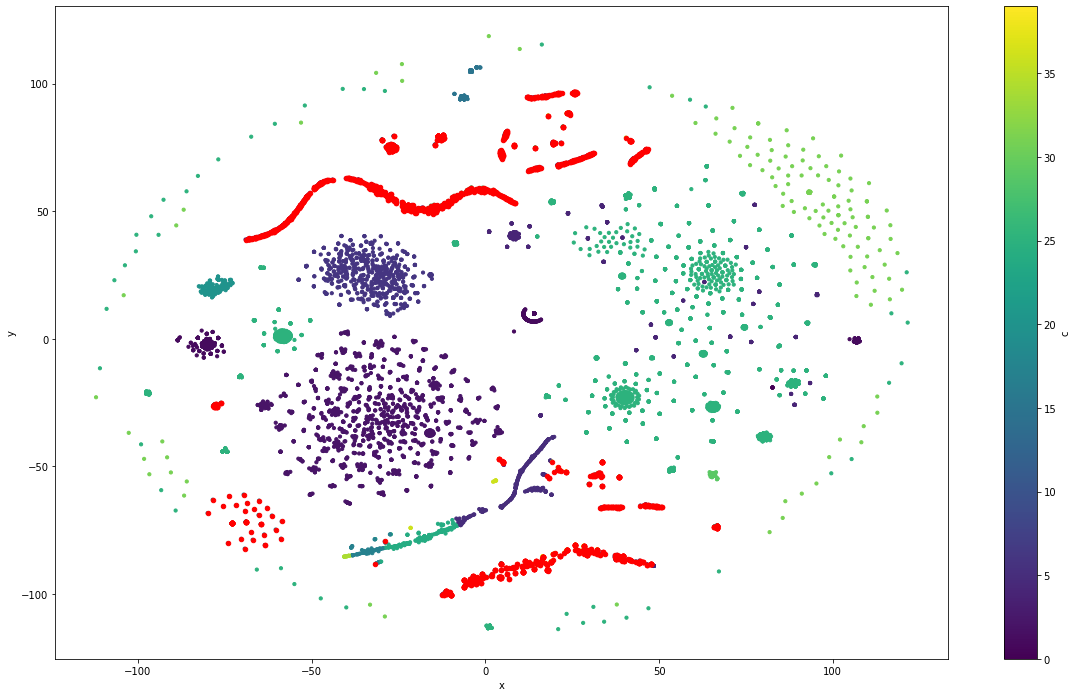

In [46]:
fig, ax = plt.subplots()
pointscluster = pd.DataFrame(
    [(chat, coord[0], coord[1], cluster) for (chat, coord, cluster) in zip(df_test['clean'], matrix_dicc2d, df_test['w2v_clusters']) ],
    columns=["word", "x", "y", "c"]
)
pointscluster.plot(ax=ax, kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))
toxic_clusters = pd.DataFrame(
    [(coord[0], coord[1]) for (coord, cluster) in zip(matrix_dicc2d, df_test['w2v_clusters']) if cluster in top_toxic_clusters ],
    columns=["x", "y"]
)
toxic_clusters.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
plt.show()